In [1]:
#Se importan las librerias que se van a ocupar. 
import numpy as np
import matplotlib.pyplot as plt 
from math import floor
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import time

In [2]:
data_raw = pd.read_csv("./Skyserver.csv")
data_raw.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [3]:
data = data_raw.loc[:, ~data_raw.columns.isin(["objid", "rerun"])]

data = pd.concat([data, pd.get_dummies(data["class"])], axis = 1)
data = data.loc[:, data.columns != "class"]
data.head()

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,redshift,plate,mjd,fiberid,GALAXY,QSO,STAR
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,4,267,3.722360e+18,-0.000009,3306,54922,491,0,0,1
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,4,267,3.638140e+17,-0.000055,323,51615,541,0,0,1
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,4,268,3.232740e+17,0.123111,287,52023,513,1,0,0
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,4,269,3.722370e+18,-0.000111,3306,54922,510,0,0,1
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,4,269,3.722370e+18,0.000590,3306,54922,512,0,0,1


In [4]:
def histogramas(*variables, data, figsize = (20, 8), subplots):
    n_vars = len(variables)
    colors = ["blue", "green", "purple", "red", "yellow", "orange"]
    subplots_list = [plt.subplot(*subplots, i) for i in range(1, n_vars + 1)]

    fig = plt.figure(figsize= figsize)
    for i, subplot in enumerate(subplots_list):
        subplot.hist(data[variables[i]], color = random.choice(colors),
                     edgecolor = "black", alpha = 0.6, bins = 20)
        subplot.set_xlabel(variables[i])
        
        if (i == 0):
            subplot.set_ylabel("Conteo", size = 15)
    plt.show()

    

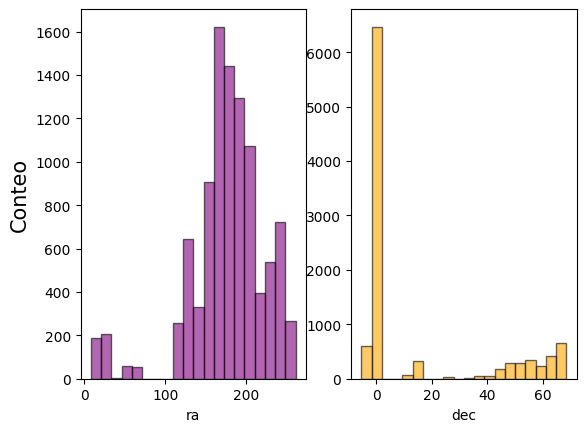

<Figure size 2000x800 with 0 Axes>

In [5]:
histogramas("ra", "dec", data = data, subplots = (1, 2))

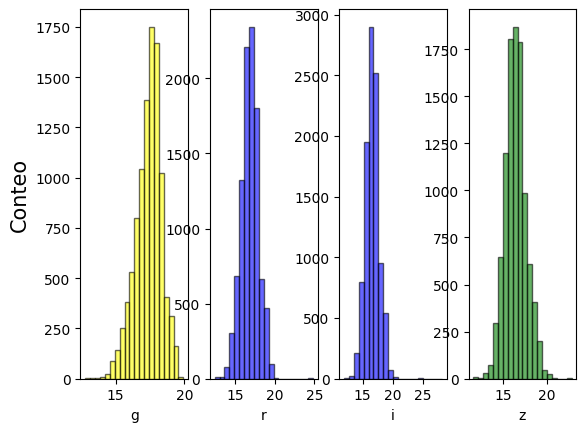

<Figure size 2000x800 with 0 Axes>

In [6]:
histogramas("g", "r", "i", "z", data = data, subplots = (1, 4))

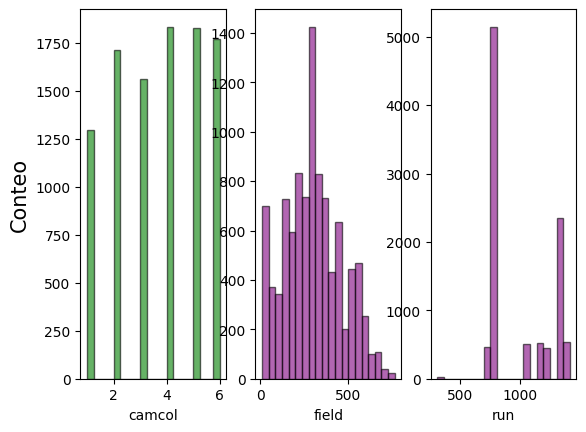

<Figure size 2000x800 with 0 Axes>

In [7]:
histogramas("camcol", "field", "run", data = data, subplots = (1, 3))

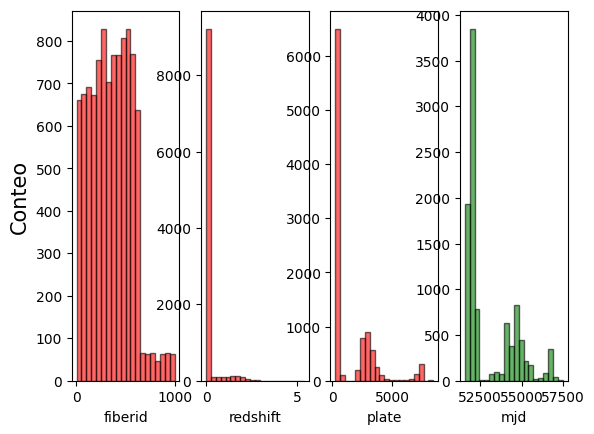

<Figure size 2000x800 with 0 Axes>

In [8]:
histogramas("fiberid", "redshift", "plate", "mjd", data = data, subplots = (1, 4))

In [9]:
def preparar_data(data):
    X = data.loc[:, ~data.columns.isin(["GALAXY", "QSO", "STAR"])]
    Y = data.loc[:, data.columns.isin(["GALAXY", "QSO", "STAR"])]
    X, Y = torch.tensor(X.values).float(), torch.tensor(Y.values).float()

    X_means = X.mean(dim = [0])
    X_std = X.std(dim = [0])
    X = (X - X_means) / X_std
    return (*train_test_split(X, Y, train_size= 0.8), X_means, X_std)


In [10]:
x_train, x_test, y_train, y_test, x_means, x_std = preparar_data(data)

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4, output_size):

        super(RNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden1, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Linear(hidden1, hidden2, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Dropout(0.6),
            nn.BatchNorm1d(hidden2),
            nn.Linear(hidden2, hidden3, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Dropout(0.6),
            nn.BatchNorm1d(hidden3),
            nn.Linear(hidden3, hidden4, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Linear(hidden4, output_size, bias = False, dtype = torch.float)
        )
    
    def feed_forward(self, X):
        out = self.layers(X)
        out = torch.nn.functional.softmax(out, dim = 1)
        return out
    
    def back_propagate(self, X, Y):
        out = self.feed_forward(X)
        f_error = nn.CrossEntropyLoss()
        error = f_error(out, Y)
        error.backward()
        return error

    def train(self, X_train, Y_train, optimizer, ciclos = 100):
        self.optimizer = optimizer
        loss = []
        for i in range(ciclos):
            self.optimizer.zero_grad()
            loss.append(self.back_propagate(X_train, Y_train).detach().numpy())
            self.optimizer.step()
        return loss



In [25]:
Red = RNN(15, 150, 150, 150, 150, 3)
optimizer = optim.Adam(Red.parameters(), lr = 0.001)

In [26]:
loss = Red.train(x_train, y_train, optimizer = optimizer, ciclos = 50)
plt.plot(loss)

In [ ]:
# Agregar predicciones y matriz de confusion

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

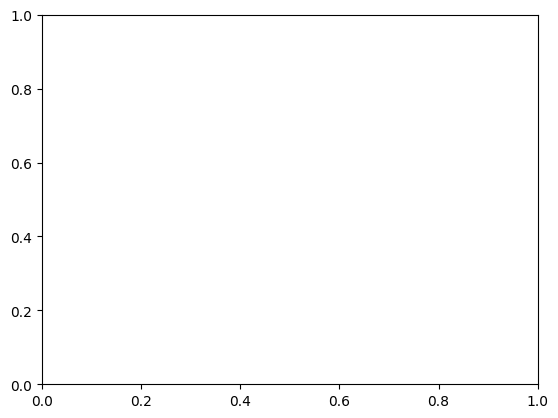

In [15]:
plt.plot(loss.de)